# (Homework) Week 6 - DataScience Bootcamp Fall 2025

All solution cells are replaced with `# TODO` placeholders so you can fill them in.

**Name:** Jiawei Zhao \
**Email:**

---

### Problem 1: Dataset Splitting

1. You have recordings of 44 phones from 100 people; each person records ~200 phones/day for 5 days.
   - Design a valid training/validation/test split strategy that ensures the model generalizes to **new speakers**.

2. You now receive an additional dataset of 10,000 phone recordings from **Kilian**, a single speaker.
   - You must train a model that performs well **specifically for Kilian**, while also maintaining generalization.

*Describe your proposed split strategy and reasoning.* (Theory)

### Part 1: Initial Dataset

Since we need to generalize to new speakers, we should split by **speaker**, not by individual recordings. If we randomly split recordings, the same speaker might appear in both training and test sets, which would give us an overoptimistic estimate.

**80-20 Split:**
- **Training:** 80 speakers (all their recordings)
- **Test:** 20 speakers (all their recordings)

This way, the test set contains completely unseen speakers, so we can properly evaluate generalization.

### Part 2: Kilian's Dataset

For Kilian's 10,000 recordings, I'd do an 80-20 split:
- **Training:** 8,000 recordings (to improve Kilian-specific performance)
- **Test:** 2,000 recordings (to evaluate Kilian-specific performance)

To balance Kilian performance with generalization:
- Combine the original training set (80 speakers) with Kilian's training set (8,000 recordings)
- During training, sample from both datasets. Maybe give Kilian's data a bit more weight since we want good performance for him
- Evaluate on both: the original test set (20 speakers) for generalization, and Kilian's test set (2,000 recordings) for Kilian-specific performance

This way we can see if the model works well for Kilian while still maintaining good performance on other speakers.



### Problem 2: K-Nearest Neighbors

1. **1-NN Classification:** Given dataset:

   Positive: (1,2), (1,4), (5,4)

   Negative: (3,1), (3,2)

   Plot the 1-NN decision boundary and classify new points visually.

2. **Feature Scaling:** Consider dataset:

   Positive: (100,2), (100,4), (500,4)

   Negative: (300,1), (300,2)

   What would the 1-NN classify point (500,1) as **before and after scaling** to [0,1] per feature?

3. **Handling Missing Values:** How can you modify K-NN to handle missing features in a test point?

4. **High-dimensional Data:** Why can K-NN still work well for images even with thousands of pixels?


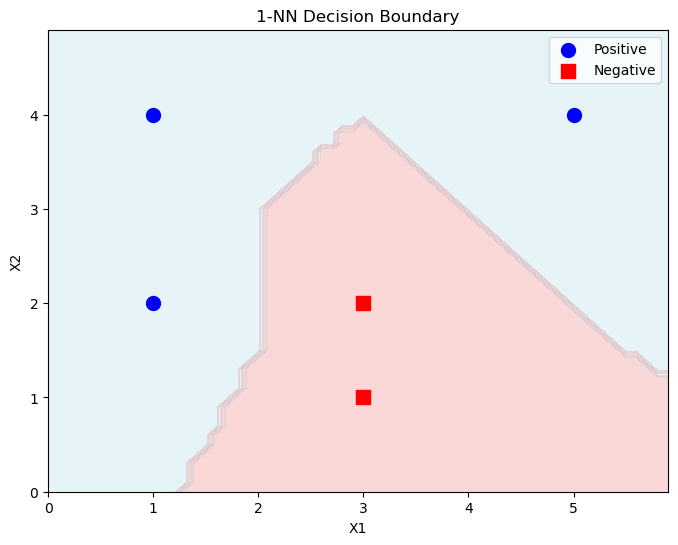

Before scaling: Positive
After scaling: Negative


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

# Problem 2.1: 1-NN Classification
positive = np.array([[1, 2], [1, 4], [5, 4]])
negative = np.array([[3, 1], [3, 2]])
X = np.vstack([positive, negative])
y = np.array([1, 1, 1, -1, -1])

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

# Plot decision boundary
xx, yy = np.meshgrid(np.arange(0, 6, 0.1), np.arange(0, 5, 0.1))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, colors=['lightcoral', 'lightblue'])
plt.scatter(positive[:, 0], positive[:, 1], c='blue', marker='o', s=100, label='Positive')
plt.scatter(negative[:, 0], negative[:, 1], c='red', marker='s', s=100, label='Negative')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('1-NN Decision Boundary')
plt.legend()
plt.show()

# Problem 2.2: Feature Scaling
X_train = np.array([[100, 2], [100, 4], [500, 4], [300, 1], [300, 2]])
y_train = np.array([1, 1, 1, -1, -1])
test = np.array([[500, 1]])

# Before scaling
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)
pred_before = knn1.predict(test)[0]
print(f"Before scaling: {'Positive' if pred_before == 1 else 'Negative'}")

# After scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(test)
knn2 = KNeighborsClassifier(n_neighbors=1)
knn2.fit(X_scaled, y_train)
pred_after = knn2.predict(test_scaled)[0]
print(f"After scaling: {'Positive' if pred_after == 1 else 'Negative'}")

### Problem 2.3: Handling Missing Values

When there are missing features, you can handle it by just ignoring the missing features when calculating distance. Only use the features that are available in both the test point and training point, and normalize by dividing by the number of available features.

Alternatively, you could fill in the missing values using the mean/median from the training data before doing K-NN. Or give lower weight to distances computed with fewer features.

### Problem 2.4: High-dimensional Data

K-NN can work well for images even with thousands of pixels because images have structure - nearby pixels are similar, so similar images still cluster together in high dimensions. Also, images have a lot of redundancy, so the actual information content is lower than the pixel count suggests.

Often we don't use raw pixels but extract features like edges first, which reduces dimensionality. Euclidean distance can still capture visual similarity in high dimensions. However, K-NN on raw pixels can be slow, so using PCA or pre-trained features might be better.


### Problem 3: Part 1

You are given a fully trained Perceptron model with weight vector **w**, along with training set **D_TR** and test set **D_TE**.

1. Your co-worker suggests evaluating $h(x) = sign(w \cdot x)$ for every $(x, y)$ in D_TR and D_TE. Does this help determine whether test error is higher than training error?
2. Why is there no need to compute training error explicitly for the Perceptron algorithm?


Yes, it does help. By evaluating h(x) on both D_TR and D_TE, you can compute the training error and test error. If test error is higher than training error, that tells you the model might be overfitting to the training data. However, this comparison only makes sense if the model was trained on D_TR - if you're just given a trained model, you can still compare the errors to see how well it generalizes.


The Perceptron algorithm only updates weights when it makes mistakes. So by the time the algorithm converges (or stops), all training examples are classified correctly, meaning the training error is zero. There's no need to compute it explicitly because we know it's zero once the algorithm stops updating.

### Problem 3: Two-point 2D Dataset (Part 2)

Run the Perceptron algorithm **by hand or in code** on the following data:

1. Positive class: (10, -2)
2. Negative class: (12, 2)

Start with $w_0 = (0, 0)$ and a learning rate of 1.

- Compute how many updates are required until convergence.
- Write down the sequence of $w_i$ vectors.

In [4]:
import numpy as np

# Problem 3.2: Perceptron algorithm
# Positive class: (10, -2) with label +1
# Negative class: (12, 2) with label -1

X = np.array([[10, -2], [12, 2]])
y = np.array([1, -1])

w = np.array([0.0, 0.0])
learning_rate = 1
updates = 0
w_history = [w.copy()]

print("Perceptron Algorithm:")
print(f"Initial w: {w}")
print()

while True:
    mistake = False
    for i in range(len(X)):
        # Check if mistake: y * (w · x) <= 0
        dot_product = np.dot(w, X[i])
        if y[i] * dot_product <= 0:
            # Update: w = w + learning_rate * y * x
            w = w + learning_rate * y[i] * X[i]
            updates += 1
            w_history.append(w.copy())
            mistake = True
            print(f"Update {updates}: Mistake on point {X[i]} (y={y[i]}), w·x={dot_product:.1f}, new w = {w}")
    
    # If no mistakes, we're done
    if not mistake:
        break

print()
print(f"Converged after {updates} updates")
print(f"Final weight vector: w = {w}")
print()
print("Sequence of weight vectors:")
for i, w_i in enumerate(w_history):
    print(f"  w_{i} = {w_i}")

Perceptron Algorithm:
Initial w: [0. 0.]

Update 1: Mistake on point [10 -2] (y=1), w·x=0.0, new w = [10. -2.]
Update 2: Mistake on point [12  2] (y=-1), w·x=116.0, new w = [-2. -4.]
Update 3: Mistake on point [10 -2] (y=1), w·x=-12.0, new w = [ 8. -6.]
Update 4: Mistake on point [12  2] (y=-1), w·x=84.0, new w = [-4. -8.]
Update 5: Mistake on point [10 -2] (y=1), w·x=-24.0, new w = [  6. -10.]
Update 6: Mistake on point [12  2] (y=-1), w·x=52.0, new w = [ -6. -12.]
Update 7: Mistake on point [10 -2] (y=1), w·x=-36.0, new w = [  4. -14.]
Update 8: Mistake on point [12  2] (y=-1), w·x=20.0, new w = [ -8. -16.]
Update 9: Mistake on point [10 -2] (y=1), w·x=-48.0, new w = [  2. -18.]

Converged after 9 updates
Final weight vector: w = [  2. -18.]

Sequence of weight vectors:
  w_0 = [0. 0.]
  w_1 = [10. -2.]
  w_2 = [-2. -4.]
  w_3 = [ 8. -6.]
  w_4 = [-4. -8.]
  w_5 = [  6. -10.]
  w_6 = [ -6. -12.]
  w_7 = [  4. -14.]
  w_8 = [ -8. -16.]
  w_9 = [  2. -18.]


### Problem 4: Reconstructing the Weight Vector

Given the log of Perceptron updates:

| x | y | count |
|---|---|--------|
| (0, 0, 0, 0, 4) | +1 | 2 |
| (0, 0, 6, 5, 0) | +1 | 1 |
| (3, 0, 0, 0, 0) | -1 | 1 |
| (0, 9, 3, 6, 0) | -1 | 1 |
| (0, 1, 0, 2, 5) | -1 | 1 |

Assume learning rate = 1 and initial weight $w_0 = (0, 0, 0, 0, 0)$.

Compute the final weight vector after all updates.

In [6]:
import numpy as np

# Problem 4: Reconstructing the Weight Vector
# Initial weight
w = np.array([0, 0, 0, 0, 0])
learning_rate = 1

# Updates from the log
updates = [
    (np.array([0, 0, 0, 0, 4]), 1, 2),   # (x, y, count)
    (np.array([0, 0, 6, 5, 0]), 1, 1),
    (np.array([3, 0, 0, 0, 0]), -1, 1),
    (np.array([0, 9, 3, 6, 0]), -1, 1),
    (np.array([0, 1, 0, 2, 5]), -1, 1),
]

print("Problem 4: Reconstructing Weight Vector")
print(f"Initial w_0 = {w}")
print()

total_updates = 0
for x, y, count in updates:
    for i in range(count):
        w = w + learning_rate * y * x
        total_updates += 1
        print(f"Update {total_updates}: w = w + {y} * {x} = {w}")

print()
print(f"Final weight vector: w = {w}")
print(f"Total updates: {total_updates}")

Problem 4: Reconstructing Weight Vector
Initial w_0 = [0 0 0 0 0]

Update 1: w = w + 1 * [0 0 0 0 4] = [0 0 0 0 4]
Update 2: w = w + 1 * [0 0 0 0 4] = [0 0 0 0 8]
Update 3: w = w + 1 * [0 0 6 5 0] = [0 0 6 5 8]
Update 4: w = w + -1 * [3 0 0 0 0] = [-3  0  6  5  8]
Update 5: w = w + -1 * [0 9 3 6 0] = [-3 -9  3 -1  8]
Update 6: w = w + -1 * [0 1 0 2 5] = [ -3 -10   3  -3   3]

Final weight vector: w = [ -3 -10   3  -3   3]
Total updates: 6


### Problem 5: Visualizing Perceptron Convergence

Implement a Perceptron on a small 2D dataset with positive and negative examples.

- Plot the data points.
- After each update, visualize the decision boundary.
- Show how it converges to a stable separator.

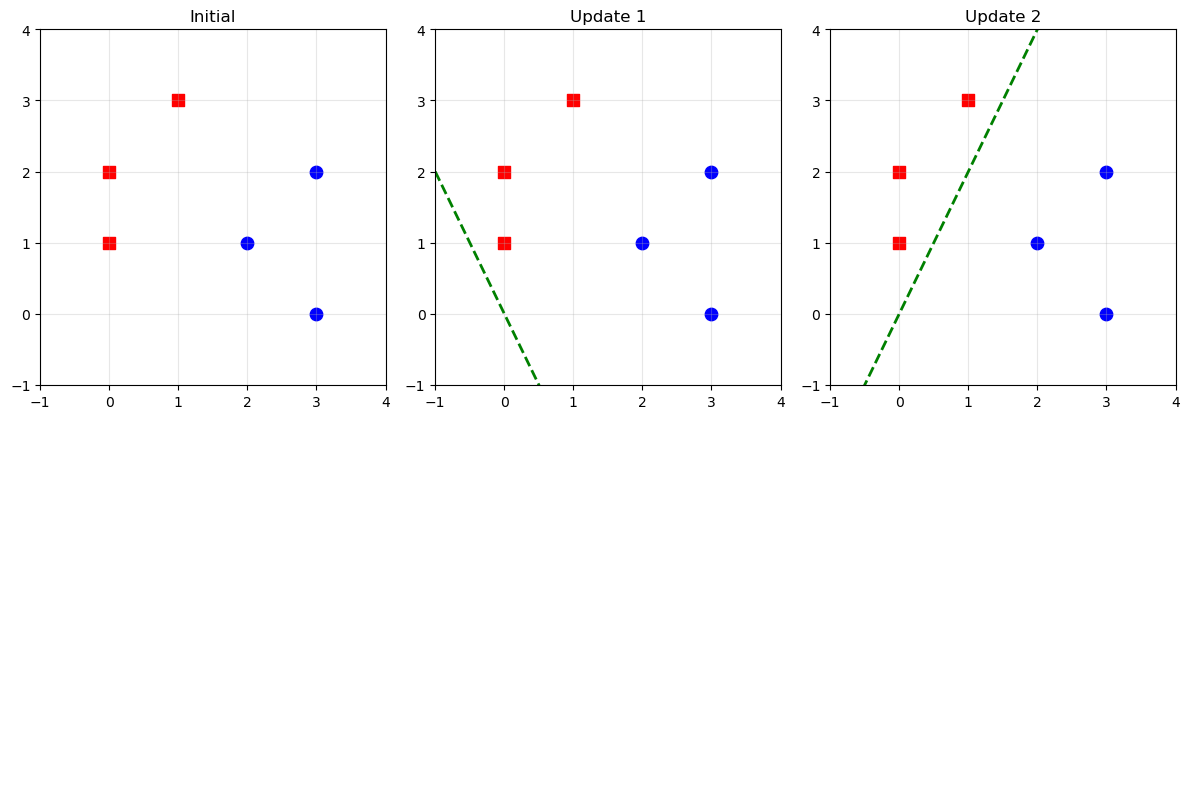

Converged after 2 updates
Final w = [ 2. -1.]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Problem 5: Visualizing Perceptron Convergence
# Simple 2D dataset that's linearly separable
positive = np.array([[2, 1], [3, 2], [3, 0]])
negative = np.array([[0, 2], [1, 3], [0, 1]])
X = np.vstack([positive, negative])
y = np.array([1, 1, 1, -1, -1, -1])

w = np.array([0.0, 0.0])
w_history = [w.copy()]

# Run Perceptron
max_iter = 100
for _ in range(max_iter):
    mistake = False
    for i in range(len(X)):
        if y[i] * np.dot(w, X[i]) <= 0:
            w = w + y[i] * X[i]
            w_history.append(w.copy())
            mistake = True
            break
    if not mistake:
        break

# Plot first 6 updates
n_plots = min(len(w_history), 6)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for idx in range(n_plots):
    w_i = w_history[idx]
    ax = axes[idx]
    ax.scatter(positive[:, 0], positive[:, 1], c='blue', marker='o', s=80, label='Positive')
    ax.scatter(negative[:, 0], negative[:, 1], c='red', marker='s', s=80, label='Negative')
    
    # Plot decision boundary: w·x = 0 => x2 = -(w[0]/w[1]) * x1
    if abs(w_i[1]) > 1e-6:
        x1 = np.linspace(-1, 4, 100)
        x2 = -(w_i[0] * x1) / w_i[1]
        ax.plot(x1, x2, 'g--', linewidth=2)
    elif abs(w_i[0]) > 1e-6:
        ax.axvline(x=0, color='g', linestyle='--', linewidth=2)
    
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 4)
    ax.set_title(f'Update {idx}' if idx > 0 else 'Initial')
    ax.grid(True, alpha=0.3)

for idx in range(n_plots, 6):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"Converged after {len(w_history)-1} updates")
print(f"Final w = {w}")
print()
# Verify the result
print("Verification:")
for i in range(len(X)):
    prediction = np.dot(w, X[i])
    correct = "✓" if (y[i] * prediction > 0) else "✗"
    print(f"Point {X[i]}, y={y[i]}: w·x = {prediction:.1f} {correct}")